**IMPORT STATEMENTS**

In [1]:
import time
import pickle
import numpy as np
import shutil
import os
from tqdm import tqdm, tqdm_notebook
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchaudio
import copy

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from IPython.display import clear_output

In [2]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
       
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')


Training on GPU.


**PREPROCESSING**

In [3]:
SAMPLE_RATE = 48000
N_FFT = SAMPLE_RATE * 64 // 1000 + 4
HOP_LENGTH = SAMPLE_RATE * 16 // 1000 + 4

In [4]:
class SpeechDataset(Dataset):

    def __init__(self, noisy_files, clean_files, n_fft=64, hop_length=16):
        super().__init__()
        # list of files
        self.noisy_files = sorted(noisy_files)
        self.clean_files = sorted(clean_files)
        
        # stft parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.len_ = len(self.noisy_files)
        
        # fixed len
        self.max_len = 165000

    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        waveform, _ = torchaudio.load(file)
        return waveform
  
    def __getitem__(self, index):
        # load to tensors and normalization
        x_clean = self.load_sample(self.clean_files[index])
        x_noisy = self.load_sample(self.noisy_files[index])
        
        # padding/cutting
        x_clean = self._prepare_sample(x_clean)
        x_noisy = self._prepare_sample(x_noisy)
        
        # Short-time Fourier transform
        x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        x_clean_stft = torch.stft(input=x_clean, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        
        return x_noisy_stft, x_clean_stft
        
    def _prepare_sample(self, waveform):
        waveform = waveform.numpy()
        current_len = waveform.shape[1]
        
        output = np.zeros((1, self.max_len), dtype='float32')
        output[0, -current_len:] = waveform[0, :self.max_len]
        output = torch.from_numpy(output)
        
        return output

In [5]:
"""TRAIN_NOISY_DIR = Path('../input/speechenhancement-dataset/dataset/dataset/noisy_trainset_28spk_wav/noisy_trainset_28spk_wav')
TRAIN_CLEAN_DIR = Path('../input/speechenhancement-dataset/dataset/dataset/clean_trainset_28spk_wav/clean_trainset_28spk_wav')

TEST_NOISY_DIR = Path('../input/speechenhancement-dataset/dataset/dataset/noisy_testset_wav/noisy_testset_wav')
TEST_CLEAN_DIR = Path('../input/speechenhancement-dataset/dataset/dataset/clean_testset_wav/clean_testset_wav')"""

"TRAIN_NOISY_DIR = Path('../input/speechenhancement-dataset/dataset/dataset/noisy_trainset_28spk_wav/noisy_trainset_28spk_wav')\nTRAIN_CLEAN_DIR = Path('../input/speechenhancement-dataset/dataset/dataset/clean_trainset_28spk_wav/clean_trainset_28spk_wav')\n\nTEST_NOISY_DIR = Path('../input/speechenhancement-dataset/dataset/dataset/noisy_testset_wav/noisy_testset_wav')\nTEST_CLEAN_DIR = Path('../input/speechenhancement-dataset/dataset/dataset/clean_testset_wav/clean_testset_wav')"

In [6]:
""""train_noisy_files = sorted(list(TRAIN_NOISY_DIR.rglob('*.wav')))
train_clean_files = sorted(list(TRAIN_CLEAN_DIR.rglob('*.wav')))

test_noisy_files = sorted(list(TEST_NOISY_DIR.rglob('*.wav')))
test_clean_files = sorted(list(TEST_CLEAN_DIR.rglob('*.wav')))"""

'"train_noisy_files = sorted(list(TRAIN_NOISY_DIR.rglob(\'*.wav\')))\ntrain_clean_files = sorted(list(TRAIN_CLEAN_DIR.rglob(\'*.wav\')))\n\ntest_noisy_files = sorted(list(TEST_NOISY_DIR.rglob(\'*.wav\')))\ntest_clean_files = sorted(list(TEST_CLEAN_DIR.rglob(\'*.wav\')))'

In [7]:
""""train_count = 100
test_count = 25

train_noisy_files = torch.utils.data.random_split(train_noisy_files, [train_count, len(train_noisy_files)-train_count])[0]
train_clean_files = torch.utils.data.random_split(train_clean_files, [train_count, len(train_clean_files)-train_count])[0]
test_noisy_files = torch.utils.data.random_split(test_noisy_files, [test_count, len(test_noisy_files)-test_count])[0]
test_clean_files = torch.utils.data.random_split(test_clean_files, [test_count, len(test_clean_files)-test_count])[0]

print(len(train_noisy_files))
print(len(test_noisy_files))
print(len(train_clean_files))
print(len(test_clean_files))"""

'"train_count = 100\ntest_count = 25\n\ntrain_noisy_files = torch.utils.data.random_split(train_noisy_files, [train_count, len(train_noisy_files)-train_count])[0]\ntrain_clean_files = torch.utils.data.random_split(train_clean_files, [train_count, len(train_clean_files)-train_count])[0]\ntest_noisy_files = torch.utils.data.random_split(test_noisy_files, [test_count, len(test_noisy_files)-test_count])[0]\ntest_clean_files = torch.utils.data.random_split(test_clean_files, [test_count, len(test_clean_files)-test_count])[0]\n\nprint(len(train_noisy_files))\nprint(len(test_noisy_files))\nprint(len(train_clean_files))\nprint(len(test_clean_files))'

In [8]:
"""test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)
train_dataset = SpeechDataset(train_noisy_files, train_clean_files, N_FFT, HOP_LENGTH)"""

'test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)\ntrain_dataset = SpeechDataset(train_noisy_files, train_clean_files, N_FFT, HOP_LENGTH)'

In [9]:
"""test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)"""

'test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)\ntrain_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)'

**MODEL DEFINITION**

In [10]:
class CConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        
        self.real_conv = nn.Conv2d(in_channels=self.in_channels, 
                                   out_channels=self.out_channels, 
                                   kernel_size=self.kernel_size, 
                                   padding=self.padding, 
                                   stride=self.stride)
        
        self.im_conv = nn.Conv2d(in_channels=self.in_channels, 
                                 out_channels=self.out_channels, 
                                 kernel_size=self.kernel_size, 
                                 padding=self.padding, 
                                 stride=self.stride)
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.im_conv.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        c_real = self.real_conv(x_real) - self.im_conv(x_im)
        c_im = self.im_conv(x_real) + self.real_conv(x_im)
        
        output = torch.stack([c_real, c_im], dim=-1)
        return output

In [11]:
class CConvTranspose2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding=0, padding=0):
        super().__init__()
        
        self.in_channels = in_channels

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.output_padding = output_padding
        self.padding = padding
        self.stride = stride
        
        self.real_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding,
                                            padding=self.padding,
                                            stride=self.stride)
        
        self.im_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding, 
                                            padding=self.padding,
                                            stride=self.stride)
        
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.im_convt.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        ct_real = self.real_convt(x_real) - self.im_convt(x_im)
        ct_im = self.im_convt(x_real) + self.real_convt(x_im)
        
        output = torch.stack([ct_real, ct_im], dim=-1)
        return output

In [12]:
class CBatchNorm2d(nn.Module):

    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        
        self.real_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.im_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                    affine=self.affine, track_running_stats=self.track_running_stats) 
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        n_real = self.real_b(x_real)
        n_im = self.im_b(x_im)  
        
        output = torch.stack([n_real, n_im], dim=-1)
        return output

In [13]:
class Encoder(nn.Module):

    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45, padding=(0,0)):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding

        self.cconv = CConv2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconv(x)
        normed = self.cbn(conved)
        acted = self.leaky_relu(normed)
        
        return acted

In [14]:
class Decoder(nn.Module):

    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45,
                 output_padding=(0,0), padding=(0,0), last_layer=False):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_padding = output_padding
        self.padding = padding
        
        self.last_layer = last_layer
        
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, output_padding=self.output_padding, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output

**MODEL DECLARATION**

In [15]:
class Custom(nn.Module):

    def __init__(self, n_fft=64, hop_length=16):
        super().__init__()
        
        # for istft
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        # downsampling/encoding
        self.downsample0 = Encoder(filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45)
        self.downsample1 = Encoder(filter_size=(7,5), stride_size=(2,2), in_channels=45, out_channels=90)
        self.downsample2 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample3 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample4 = Encoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=90)
        
        # upsampling/decoding
        self.upsample0 = Decoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=90)
        self.upsample1 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90)
        self.upsample2 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90)
        self.upsample3 = Decoder(filter_size=(7,5), stride_size=(2,2), in_channels=180, out_channels=45)
        self.upsample4 = Decoder(filter_size=(7,5), stride_size=(2,2), in_channels=90, output_padding=(0,1),
                                 out_channels=1, last_layer=True)
        
        
    def forward(self, x, is_istft=True):
        # downsampling/encoding
        d0 = self.downsample0(x)
        d1 = self.downsample1(d0) 
        d2 = self.downsample2(d1)        
        d3 = self.downsample3(d2)        
        d4 = self.downsample4(d3)
        
        # upsampling/decoding 
        u0 = self.upsample0(d4)
        # skip-connection
        c0 = torch.cat((u0, d3), dim=1)
        
        u1 = self.upsample1(c0)
        c1 = torch.cat((u1, d2), dim=1)
        
        u2 = self.upsample2(c1)
        c2 = torch.cat((u2, d1), dim=1)
        
        u3 = self.upsample3(c2)
        c3 = torch.cat((u3, d0), dim=1)
        
        u4 = self.upsample4(c3)
        
        # u4 - the mask
        output = u4 * x
        if is_istft:
            output = torch.squeeze(output, 1)
            output = torch.istft(output, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True)
        
        return output

**TRAINING AND TESTING**

In [16]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for noisy_x, clean_x in train_loader:

        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)

        # zero  gradients
        net.zero_grad()

        # get the output from the model
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1

    train_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    return train_ep_loss

In [17]:
def test_epoch(net, test_loader, loss_fn):
    net.eval()
    test_ep_loss = 0.
    counter = 0.
    for noisy_x, clean_x in test_loader:
        # get the output from the model
        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        test_ep_loss += loss.item() 
        
        counter += 1

    test_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    
    return test_ep_loss

In [18]:
def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs):
    
    train_losses = []
    test_losses = []

    for e in tqdm(range(epochs)):

        # first evaluating for comparison
        if e == 0:
            with torch.no_grad():
                test_loss = test_epoch(net, test_loader, loss_fn)
                
            test_losses.append(test_loss)
            print("Loss before training:{:.6f}".format(test_loss))
          

        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        scheduler.step()
        with torch.no_grad():
          test_loss = test_epoch(net, test_loader, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # clear cache
        torch.cuda.empty_cache()
        gc.collect()

        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Test Loss: {:.6f}".format(test_loss))
    return train_losses, test_losses

**INITIALISE AND TRAIN THE MODEL FROM SCRATCH**

In [19]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [20]:
import torch
custom = Custom(N_FFT, HOP_LENGTH).to(DEVICE)

In [21]:
loss_fn = nn.ReLU(inplace=False)
optimizer = torch.optim.Adam(custom.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

START TRAINING

In [22]:
#train_losses, test_losses = train(custom, train_loader, test_loader, loss_fn, optimizer, scheduler, 3)

**LOAD TRAINED MODEL**

In [23]:
custom.load_state_dict(torch.load("../input/weights/__weights.pth"))

<All keys matched successfully>

**ACTUAL VOICE RECORDING TESTING**

In [24]:
VALIDATION_NOISY_DIR = Path('../input/pk-test-audio/cafe')
#VALIDATION_NOISY_DIR = Path('../input/pk-test-audio/vehicle')
#VALIDATION_NOISY_DIR = Path('../input/pk-test-audio/white')
VALIDATION_CLEAN_DIR = Path('../input/pk-test-audio/cafe')
validation_noisy_files = sorted(list(VALIDATION_NOISY_DIR.rglob('*.wav')))
validation_clean_files = sorted(list(VALIDATION_CLEAN_DIR.rglob('*.wav')))

validation_dataset = SpeechDataset(validation_noisy_files, validation_clean_files, N_FFT, HOP_LENGTH)

validation_loader = DataLoader(validation_dataset, batch_size=2, shuffle=True)

**VALIDATION**

In [25]:
"""VALIDATION_NOISY_DIR = Path('../input/validation-from-dataset/Validation/Noisy speech')
VALIDATION_CLEAN_DIR = Path('../input/validation-from-dataset/Validation/Clean speech')

validation_noisy_files = sorted(list(VALIDATION_NOISY_DIR.rglob('*.wav')))
validation_clean_files = sorted(list(VALIDATION_CLEAN_DIR.rglob('*.wav')))

validation_dataset = SpeechDataset(validation_noisy_files, validation_clean_files, N_FFT, HOP_LENGTH)

validation_loader = DataLoader(validation_dataset, batch_size=2, shuffle=True)"""

"VALIDATION_NOISY_DIR = Path('../input/validation-from-dataset/Validation/Noisy speech')\nVALIDATION_CLEAN_DIR = Path('../input/validation-from-dataset/Validation/Clean speech')\n\nvalidation_noisy_files = sorted(list(VALIDATION_NOISY_DIR.rglob('*.wav')))\nvalidation_clean_files = sorted(list(VALIDATION_CLEAN_DIR.rglob('*.wav')))\n\nvalidation_dataset = SpeechDataset(validation_noisy_files, validation_clean_files, N_FFT, HOP_LENGTH)\n\nvalidation_loader = DataLoader(validation_dataset, batch_size=2, shuffle=True)"

In [26]:
custom.eval()
x_n, x_c = iter(validation_loader).next()
x_est = custom(x_n.cuda(), is_istft=True)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:472: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/SpectralOps.cpp:661.)
  normalized, onesided, return_complex)
/opt/conda/lib/python3.7/site-packages/torch/functional.py:546: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/SpectralOps.cpp:815.)
  normalized, onesided, length, return_complex)


**VISUALISE RESULTS**

NOISY SPEECH

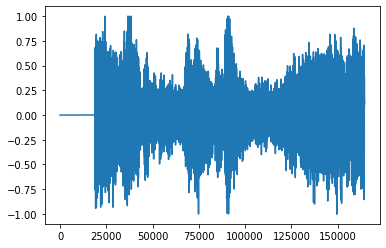

In [27]:
x_n = torch.squeeze(x_n, 1)
plt.plot(torch.istft(x_n, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy())
x_n = torch.istft(x_n, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)

PREDICTED SPEECH

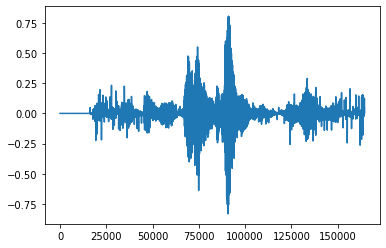

In [28]:
plt.plot(x_est.view(-1).detach().cpu().numpy())

CLEAN SPEECH

In [29]:
"""x_c = torch.squeeze(x_c, 1)
plt.plot(torch.istft(x_c, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy())
x_c = torch.istft(x_c, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)"""

'x_c = torch.squeeze(x_c, 1)\nplt.plot(torch.istft(x_c, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy())\nx_c = torch.istft(x_c, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)'

SHAPE OF THE AUDIO TENSORS

In [30]:
print(x_n.size())
print(x_c.size())
print(x_est.size())

torch.Size([1, 164436])
torch.Size([1, 1, 1539, 214, 2])
torch.Size([1, 164436])


In [31]:
x_est = torch.unsqueeze(x_est, 1)
x_n = torch.unsqueeze(x_n, 1)
x_c = torch.unsqueeze(x_c, 1)

In [32]:
print(x_n.size())
print(x_c.size())
print(x_est.size())

torch.Size([1, 1, 164436])
torch.Size([1, 1, 1, 1539, 214, 2])
torch.Size([1, 1, 164436])


**CONVERT TENSOR TO NUMPY ARRAY**

In [33]:
#np_arr_1 = x_n.detach().cpu().numpy()
#np_arr_2 = x_c.detach().cpu().numpy()
np_arr_3 = x_est.detach().cpu().numpy()

**CONVERT NUMPY ARRAY TO AUDIO WAV FILE**

In [34]:
import numpy as np
from scipy.io.wavfile import write

#data = np.random.uniform(-1,1,44100) # 44100 random samples between -1 and 1
#data = np_arr_1
#scaled = np.int16(data/np.max(np.abs(data)) * 32767)
#write('noisy.wav', 44100, scaled)

#data = np_arr_2
#scaled = np.int16(data/np.max(np.abs(data)) * 32767)
#write('clean.wav', 48000, scaled)

data = np_arr_3
scaled = np.int16(data/np.max(np.abs(data)) * 32767)
write('predicted_cafe.wav', 44100, scaled)
#write('predicted_vehicle.wav', 44100, scaled)
#write('predicted_white.wav', 44100, scaled)

REMOVE OUTPUT FILES IF NEEDED

In [35]:
os.remove("/kaggle/working/predicted_cafe.wav")
#os.remove("/kaggle/working/predicted_vehicle.wav")
#os.remove("/kaggle/working/predicted_white.wav")
#os.remove("/kaggle/working/clean.wav")
#os.remove("/kaggle/working/noisy.wav")

**EVALUATION METRICS**

PESQ SCORE (Perceptual Evaluation of Speech Quality)

In [36]:
#pip install https://github.com/ludlows/python-pesq/archive/master.zip

In [37]:
"""rom scipy.io import wavfile
from pesq import pesq

rate, ref = wavfile.read("../input/data-for-metrics/Metrics/clean.wav")
rate, deg = wavfile.read("../input/data-for-metrics/Metrics/predicted.wav")

print(pesq(16000, ref, deg, 'wb'))
print(pesq(8000, ref, deg, 'nb'))
print(pesq(16000, ref, deg, 'nb'))"""

'rom scipy.io import wavfile\nfrom pesq import pesq\n\nrate, ref = wavfile.read("../input/data-for-metrics/Metrics/clean.wav")\nrate, deg = wavfile.read("../input/data-for-metrics/Metrics/predicted.wav")\n\nprint(pesq(16000, ref, deg, \'wb\'))\nprint(pesq(8000, ref, deg, \'nb\'))\nprint(pesq(16000, ref, deg, \'nb\'))'

STOI SCORE (Short-Time Objective Intelligibility Measure)

In [38]:
#pip install pystoi

In [39]:
"""import soundfile as sf
from pystoi import stoi

clean, fs = sf.read("../input/data-for-metrics/Metrics/clean.wav")
denoised, fs = sf.read("../input/data-for-metrics/Metrics/predicted.wav")

# Clean and den should have the same length, and be 1D
d = stoi(clean, denoised, fs, extended=False)
print(d)"""

'import soundfile as sf\nfrom pystoi import stoi\n\nclean, fs = sf.read("../input/data-for-metrics/Metrics/clean.wav")\ndenoised, fs = sf.read("../input/data-for-metrics/Metrics/predicted.wav")\n\n# Clean and den should have the same length, and be 1D\nd = stoi(clean, denoised, fs, extended=False)\nprint(d)'

**MIX CLEAN SPEECH WITH DIFFERENT TYPES OF NOISES FOR FURTHER TESTING**

CREATE VIRTUAL ENVIRONMENT

In [40]:
#pip install --user pipenv

FOR 16-BIT PCM ONLY

In [41]:
"""def cal_adjusted_rms(clean_rms, snr):
    a = float(snr) / 20
    noise_rms = clean_rms / (10**a) 
    return noise_rms

def cal_amp(wf):
    buffer = wf.readframes(wf.getnframes())
    # The dtype depends on the value of pulse-code modulation. The int16 is set for 16-bit PCM.
    amptitude = (np.frombuffer(buffer, dtype="int16")).astype(np.float64)
    return amptitude

def cal_rms(amp):
    return np.sqrt(np.mean(np.square(amp), axis=-1))

def save_waveform(output_path, params, amp):
    output_file = wave.Wave_write(output_path)
    output_file.setparams(params) #nchannels, sampwidth, framerate, nframes, comptype, compname
    output_file.writeframes(array.array('h', amp.astype(np.int16)).tobytes() )
    output_file.close()"""

'def cal_adjusted_rms(clean_rms, snr):\n    a = float(snr) / 20\n    noise_rms = clean_rms / (10**a) \n    return noise_rms\n\ndef cal_amp(wf):\n    buffer = wf.readframes(wf.getnframes())\n    # The dtype depends on the value of pulse-code modulation. The int16 is set for 16-bit PCM.\n    amptitude = (np.frombuffer(buffer, dtype="int16")).astype(np.float64)\n    return amptitude\n\ndef cal_rms(amp):\n    return np.sqrt(np.mean(np.square(amp), axis=-1))\n\ndef save_waveform(output_path, params, amp):\n    output_file = wave.Wave_write(output_path)\n    output_file.setparams(params) #nchannels, sampwidth, framerate, nframes, comptype, compname\n    output_file.writeframes(array.array(\'h\', amp.astype(np.int16)).tobytes() )\n    output_file.close()'

In [42]:
# -*- coding: utf-8 -*-
"""import argparse
import array
import math
import numpy as np
import random
import wave

class create_mixed_audio_file_16bit():
    #args = get_args()

    def __init__(self, clean_file, noise_file, snr, mixed_output):
        super().__init__()
        self.clean_file = clean_file
        self.noise_file = noise_file
        self.snr = snr
        self.mixed_output = mixed_output

        clean_wav = wave.open(clean_file, "r")
        noise_wav = wave.open(noise_file, "r")

        clean_amp = cal_amp(clean_wav)
        noise_amp = cal_amp(noise_wav)

        clean_rms = cal_rms(clean_amp)

        start = random.randint(0, len(noise_amp)-len(clean_amp))
        divided_noise_amp = noise_amp[start: start + len(clean_amp)]
        noise_rms = cal_rms(divided_noise_amp)

        #snr = args.snr
        adjusted_noise_rms = cal_adjusted_rms(clean_rms, snr)

        adjusted_noise_amp = divided_noise_amp * (adjusted_noise_rms / noise_rms) 
        mixed_amp = (clean_amp + adjusted_noise_amp)

        #Avoid clipping noise
        max_int16 = np.iinfo(np.int16).max
        min_int16 = np.iinfo(np.int16).min
        if mixed_amp.max(axis=0) > max_int16 or mixed_amp.min(axis=0) < min_int16:
            if mixed_amp.max(axis=0) >= abs(mixed_amp.min(axis=0)): 
                reduction_rate = max_int16 / mixed_amp.max(axis=0)
            else :
                reduction_rate = min_int16 / mixed_amp.min(axis=0)
            mixed_amp = mixed_amp * (reduction_rate)
            clean_amp = clean_amp * (reduction_rate)

        save_waveform(mixed_output, clean_wav.getparams(), mixed_amp)"""

'import argparse\nimport array\nimport math\nimport numpy as np\nimport random\nimport wave\n\nclass create_mixed_audio_file_16bit():\n    #args = get_args()\n\n    def __init__(self, clean_file, noise_file, snr, mixed_output):\n        super().__init__()\n        self.clean_file = clean_file\n        self.noise_file = noise_file\n        self.snr = snr\n        self.mixed_output = mixed_output\n\n        clean_wav = wave.open(clean_file, "r")\n        noise_wav = wave.open(noise_file, "r")\n\n        clean_amp = cal_amp(clean_wav)\n        noise_amp = cal_amp(noise_wav)\n\n        clean_rms = cal_rms(clean_amp)\n\n        start = random.randint(0, len(noise_amp)-len(clean_amp))\n        divided_noise_amp = noise_amp[start: start + len(clean_amp)]\n        noise_rms = cal_rms(divided_noise_amp)\n\n        #snr = args.snr\n        adjusted_noise_rms = cal_adjusted_rms(clean_rms, snr)\n\n        adjusted_noise_amp = divided_noise_amp * (adjusted_noise_rms / noise_rms) \n        mixed_amp

FOR 16-BIT PCM, 32-BIT PCM, 32-BIT FLOAT, 64-BIT FLOAT

In [43]:
"""# -*- coding: utf-8 -*-
import argparse
import numpy as np
import random
import soundfile as sf
from enum import Enum


class EncodingType(Enum):
    def __new__(cls, *args, **kwds):
        value = len(cls.__members__) + 4
        obj = object.__new__(cls)
        obj._value_ = value
        return obj

    def __init__(self, dtype, description, subtype, maximum, minimum):
        self.dtype = dtype
        self.description = description
        self.subtype = subtype
        self.maximum = maximum
        self.minimum = minimum

    # Available subtypes
    # See. https://pysoundfile.readthedocs.io/en/latest/#soundfile.available_subtypes
    INT16 = (
        "int16",
        "Signed 16 bit PCM",
        "PCM_16",
        np.iinfo(np.int16).max,
        np.iinfo(np.int16).min,
    )
    INT32 = (
        "int32",
        "Signed 32 bit PCM",
        "PCM_32",
        np.iinfo(np.int32).max,
        np.iinfo(np.int32).min,
    )
    FLOAT32 = ("float32", "32 bit float", "FLOAT", 1, -1)
    FLOAT64 = ("float64", "64 bit float", "DOUBLE", 1, -1)"""

'# -*- coding: utf-8 -*-\nimport argparse\nimport numpy as np\nimport random\nimport soundfile as sf\nfrom enum import Enum\n\n\nclass EncodingType(Enum):\n    def __new__(cls, *args, **kwds):\n        value = len(cls.__members__) + 4\n        obj = object.__new__(cls)\n        obj._value_ = value\n        return obj\n\n    def __init__(self, dtype, description, subtype, maximum, minimum):\n        self.dtype = dtype\n        self.description = description\n        self.subtype = subtype\n        self.maximum = maximum\n        self.minimum = minimum\n\n    # Available subtypes\n    # See. https://pysoundfile.readthedocs.io/en/latest/#soundfile.available_subtypes\n    INT16 = (\n        "int16",\n        "Signed 16 bit PCM",\n        "PCM_16",\n        np.iinfo(np.int16).max,\n        np.iinfo(np.int16).min,\n    )\n    INT32 = (\n        "int32",\n        "Signed 32 bit PCM",\n        "PCM_32",\n        np.iinfo(np.int32).max,\n        np.iinfo(np.int32).min,\n    )\n    FLOAT32 = ("f

In [44]:
"""class create_mixed_audio_file_all_types():

    def __init__(self, clean_file, noise_file, snr, mixed_output):
        super().__init__()
        
        #args = get_args()

        self.clean_file = clean_file
        self.noise_file = noise_file
        self.snr = snr
        self.mixed_output = mixed_output

        metadata = sf.info(clean_file)
        for item in EncodingType:
            if item.description == metadata.subtype_info:
                encoding_type = item

        clean_amp, clean_samplerate = sf.read(clean_file, dtype=encoding_type.dtype)
        noise_amp, noise_samplerate = sf.read(noise_file, dtype=encoding_type.dtype)

        clean_rms = cal_rms(clean_amp)

        start = random.randint(0, len(noise_amp) - len(clean_amp))
        divided_noise_amp = noise_amp[start : start + len(clean_amp)]
        noise_rms = cal_rms(divided_noise_amp)

        #snr = args.snr
        adjusted_noise_rms = cal_adjusted_rms(clean_rms, snr)

        adjusted_noise_amp = divided_noise_amp * (adjusted_noise_rms / noise_rms)
        mixed_amp = clean_amp + adjusted_noise_amp

        # Avoid clipping noise
        max_limit = encoding_type.maximum
        min_limit = encoding_type.minimum
        if mixed_amp.max(axis=0) > max_limit or mixed_amp.min(axis=0) < min_limit:
            if mixed_amp.max(axis=0) >= abs(mixed_amp.min(axis=0)):
                reduction_rate = max_limit / mixed_amp.max(axis=0)
            else:
                reduction_rate = min_limit / mixed_amp.min(axis=0)
            mixed_amp = mixed_amp * (reduction_rate)
            clean_amp = clean_amp * (reduction_rate)

        save_waveform(
            mixed_output, mixed_amp, clean_samplerate, encoding_type.subtype
        )
    
 #   def get_args():
 #       parser = argparse.ArgumentParser()
 #       parser.add_argument("--clean_file", type=str, required=True)
 #       parser.add_argument("--noise_file", type=str, required=True)
 #       parser.add_argument("--output_mixed_file", type=str, default="", required=True)
 #       parser.add_argument("--output_clean_file", type=str, default="")
 #       parser.add_argument("--output_noise_file", type=str, default="")
 #       parser.add_argument("--snr", type=float, default="", required=True)
 #       args = parser.parse_args()
 #       return args


    def cal_adjusted_rms(clean_rms, snr):
        a = float(snr) / 20
        noise_rms = clean_rms / (10 ** a)
        return noise_rms


    def cal_rms(amp):
        return np.sqrt(np.mean(np.square(amp), axis=-1))


    def save_waveform(output_path, amp, samplerate, subtype):
        sf.write(output_path, amp, samplerate, format="wav", subtype=subtype)"""

'class create_mixed_audio_file_all_types():\n\n    def __init__(self, clean_file, noise_file, snr, mixed_output):\n        super().__init__()\n        \n        #args = get_args()\n\n        self.clean_file = clean_file\n        self.noise_file = noise_file\n        self.snr = snr\n        self.mixed_output = mixed_output\n\n        metadata = sf.info(clean_file)\n        for item in EncodingType:\n            if item.description == metadata.subtype_info:\n                encoding_type = item\n\n        clean_amp, clean_samplerate = sf.read(clean_file, dtype=encoding_type.dtype)\n        noise_amp, noise_samplerate = sf.read(noise_file, dtype=encoding_type.dtype)\n\n        clean_rms = cal_rms(clean_amp)\n\n        start = random.randint(0, len(noise_amp) - len(clean_amp))\n        divided_noise_amp = noise_amp[start : start + len(clean_amp)]\n        noise_rms = cal_rms(divided_noise_amp)\n\n        #snr = args.snr\n        adjusted_noise_rms = cal_adjusted_rms(clean_rms, snr)\n\n    

SPECIFY PATH OF CLEAN FILE, NOISE FILE AND OUTPUT DIRECTORY

In [45]:
"""clean_file = "../input/noise-data/mixing data/16_bit/source_clean/arctic_a0001.wav"
noise_file = "../input/noise-data/mixing data/16_bit/source_noise/car/car.wav"
snr = -20
output_mixed = "./mixed.wav"
create_mixed_audio_file_16bit(clean_file, noise_file, snr, output_mixed)"""

'clean_file = "../input/noise-data/mixing data/16_bit/source_clean/arctic_a0001.wav"\nnoise_file = "../input/noise-data/mixing data/16_bit/source_noise/car/car.wav"\nsnr = -20\noutput_mixed = "./mixed.wav"\ncreate_mixed_audio_file_16bit(clean_file, noise_file, snr, output_mixed)'

In [46]:
#os.remove("/kaggle/working/mixed.wav")

**TEST FOR MANUALLY PRODUCED NOISY SPEECH**

In [47]:
"""VALIDATION_NOISY_DIR = Path('../input/validation-mixed-audio/validation from mixed audio/Noisy/car')
VALIDATION_CLEAN_DIR = Path('../input/validation-mixed-audio/validation from mixed audio/Clean')

validation_noisy_files = sorted(list(VALIDATION_NOISY_DIR.rglob('*.wav')))
validation_clean_files = sorted(list(VALIDATION_CLEAN_DIR.rglob('*.wav')))

validation_dataset = SpeechDataset(validation_noisy_files, validation_clean_files, N_FFT, HOP_LENGTH)

validation_loader = DataLoader(validation_dataset, batch_size=2, shuffle=True)"""

"VALIDATION_NOISY_DIR = Path('../input/validation-mixed-audio/validation from mixed audio/Noisy/car')\nVALIDATION_CLEAN_DIR = Path('../input/validation-mixed-audio/validation from mixed audio/Clean')\n\nvalidation_noisy_files = sorted(list(VALIDATION_NOISY_DIR.rglob('*.wav')))\nvalidation_clean_files = sorted(list(VALIDATION_CLEAN_DIR.rglob('*.wav')))\n\nvalidation_dataset = SpeechDataset(validation_noisy_files, validation_clean_files, N_FFT, HOP_LENGTH)\n\nvalidation_loader = DataLoader(validation_dataset, batch_size=2, shuffle=True)"

In [48]:
"""custom.eval()
x_n, x_c = iter(validation_loader).next()
x_est = custom(x_n.cuda(), is_istft=True)"""

'custom.eval()\nx_n, x_c = iter(validation_loader).next()\nx_est = custom(x_n.cuda(), is_istft=True)'

NOISY SPEECH

In [49]:
"""x_n = torch.squeeze(x_n, 1)
plt.plot(torch.istft(x_n, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy())
x_n = torch.istft(x_n, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)"""

'x_n = torch.squeeze(x_n, 1)\nplt.plot(torch.istft(x_n, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy())\nx_n = torch.istft(x_n, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)'

CLEAN SPEECH

In [50]:
"""x_c = torch.squeeze(x_c, 1)
plt.plot(torch.istft(x_c, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy())
x_c = torch.istft(x_c, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)"""

'x_c = torch.squeeze(x_c, 1)\nplt.plot(torch.istft(x_c, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy())\nx_c = torch.istft(x_c, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)'

PREDICTED SPEECH

In [51]:
#plt.plot(x_est.view(-1).detach().cpu().numpy())

In [52]:
"""x_est = torch.unsqueeze(x_est, 1)
x_est.size()"""

'x_est = torch.unsqueeze(x_est, 1)\nx_est.size()'

In [53]:
"""np_arr_3 = x_est.detach().cpu().numpy()
data = np_arr_3
scaled = np.int16(data/np.max(np.abs(data)) * 32767)
#write('car-predicted.wav', 48000, scaled)"""

"np_arr_3 = x_est.detach().cpu().numpy()\ndata = np_arr_3\nscaled = np.int16(data/np.max(np.abs(data)) * 32767)\n#write('car-predicted.wav', 48000, scaled)"

RESAMPLE FROM 44KHZ (16-BIT PCM) TO 48KHZ

In [54]:
"""#pip install librosa
import librosa    
y, s = librosa.load('./car-predicted.wav', sr=48000)"""

"#pip install librosa\nimport librosa    \ny, s = librosa.load('./car-predicted.wav', sr=48000)"

In [55]:
"""y = y[np.newaxis]
y = y[np.newaxis]"""

'y = y[np.newaxis]\ny = y[np.newaxis]'

In [56]:
"""print(y)
print(y.ndim)"""

'print(y)\nprint(y.ndim)'

In [57]:
"""data = y
scaled = np.int16(data/np.max(np.abs(data)) * 32767)
write('car-predicted_48k.wav', 48000, scaled)"""

"data = y\nscaled = np.int16(data/np.max(np.abs(data)) * 32767)\nwrite('car-predicted_48k.wav', 48000, scaled)"